# <font color='deepskyblue'>Cosmology MCMC notebook </font>

## <font color='deepskyblue'>Preliminaries</font>

In [1]:
# Install required packages (if not available on server)
try:
  import getdist
except:
  !pip install getdist
  import getdist

# Load required packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate

# import pylab
import getdist, IPython, time
from numpy import random

# from IPython.display import Image
from getdist import plots, MCSamples, loadMCSamples

# just for printing! calculations should be performed with machine precision
%precision 3

'%.3f'


<font color='tomato'>
(NB: The equations you'll directly need to build your code are those $\boxed{\text{with a box around}}$)
</font>

## <font color='deepskyblue'>The $\Lambda$CDM Model</font>

The Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$. While photons (light rays) travel in the expanding universe they get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$


In the $\Lambda$CDM model (and at late enough times), this additionally simplifies to

$$
\begin{gathered}
\boxed{
H^2 = H_0^2\left[\Omega_\Lambda + \Omega_m (1+z)^3 + \Omega_k (1+z)^2\right]
}
\\
\boxed{
\Omega_m + \Omega_\Lambda + \Omega_k = 1
}
\end{gathered}
\tag{1}
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. NB: only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
\boxed{
  H_0 \equiv 100\,h\,\frac{\rm km}{\rm s\,Mpc}
}
\tag{2}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{16}$ m.

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

In [2]:
H0 = lambda h: h*100 # current hubble rate H0 in km/s/Mpc
c = 299792. # speed of light in km/s

In [3]:
# Hubble rate: look at equations (1) and (2) for the definition!
def Hubble(z, OmegaL, OmegaM, h):
    OmegaK = 1. - OmegaL - OmegaM
    H = H0(h) * np.sqrt((OmegaL + OmegaM * (1+z)**3 + OmegaK * (1+z)**2))
    return H

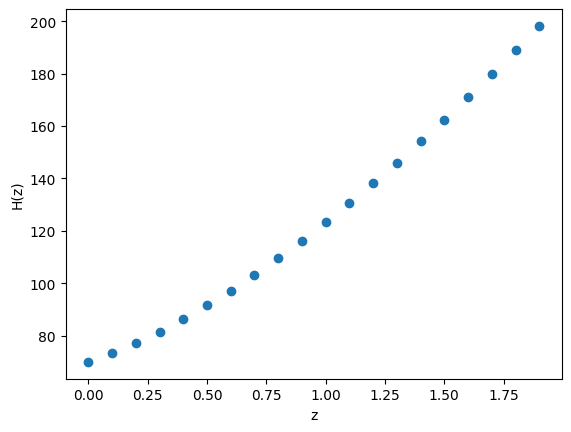

In [4]:
%matplotlib inline
OmegaL = 0.7
OmegaM = 0.3
h = 0.7

zs = np.arange(0, 2.0, 0.1)
Hs = []
for z in zs:
  Hs += [Hubble(z, OmegaL, OmegaM, h)]

plt.scatter(zs, Hs)
plt.xlabel('z')
plt.ylabel('H(z)')
plt.show()

## <font color='deepskyblue'>Supernovae Ia</font>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

We can express the luminosity distance in terms of the Hubble rate:

$$
\boxed{
d_L(z) = \frac{c}{H_0}(1+z) \times
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \,\sinh\left(\sqrt{\Omega_k}\,D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k = 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \,\sin\left(\sqrt{-\Omega_k}\,D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
}
\tag{3}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history.
In practice, however, the actual observable for [Supernovae Type Ia](https://en.wikipedia.org/wiki/Type_Ia_supernova) (or SNIa) is the [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$, defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
\tag{4}
$$

We can create the function `dL(z, h, Omega_m, Omega_Lambda)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator, for example implementing the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) or your favourite alternative, or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in units of 100 km/s/Mpc (which we called $h$).

In [5]:
# Integrate 1/H from x = 0 to x = z
def D(z, OmegaM, OmegaL, h): # Yes, you can pass a function as argument!
    # This is how you integrate with integrate.quad;
    # (...)[0] gives the result of the integral; (...)[1] is the error estimate; see manual for details
    return H0(h) * integrate.quad(lambda x: 1/Hubble(x, OmegaL, OmegaM, h), 0, z)[0]

# Let's just print a sample result
#display(D(1., Hubble))


def dL(z, OmegaM, OmegaL, h): # luminosity distance, use eq.(3)
    OmegaK = 1. - OmegaL - OmegaM
    Dz = D(z, OmegaL, OmegaM, h)

    if(OmegaK > 0):
      dL = 1 / np.sqrt(OmegaK) * np.sinh(np.sqrt(OmegaK) * Dz)
    if(OmegaK == 0):
      dL = Dz
    if(OmegaK < 0):
      dL = 1 / np.sqrt(-OmegaK) * np.sin(np.sqrt(-OmegaK) * Dz)

    dL *= c / H0(h) * (1+z) # luminosity distance in Mpc
    return dL

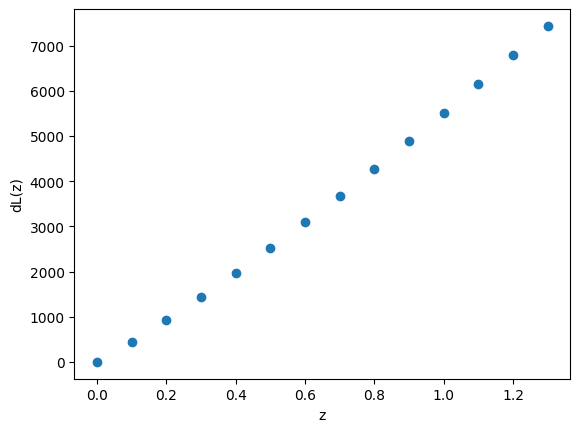

In [6]:
# test dL function

OmegaL = 0.7
OmegaM = 0.3
h     = 0.7

zs = np.arange(0, 1.4, 0.1)
dLs = []
for z in zs:
  dLs += [dL(z, OmegaM, OmegaL, h)]

plt.scatter(zs, dLs)
plt.xlabel('z')
plt.ylabel('dL(z)')
plt.show()

In [7]:
def mu(z, OmegaM, OmegaL, h): # distance modulus -- use eq.(4)
    #using luminosity distance to calculate distance modulus
    dl = dL(z, OmegaM, OmegaL, h)
    # converting dl from Mpc to pc
    muz = 5 * np.log10(dl*1e6 / 10)
    return  muz

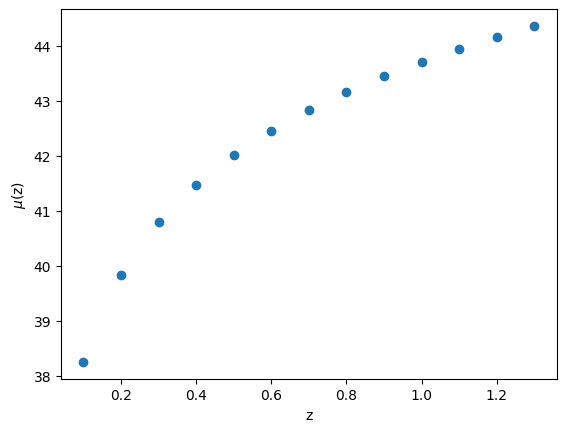

In [8]:
# test mu function

OmegaL = 0.7
OmegaM = 0.3
h     = 0.7

zs = np.arange(0.1, 1.4, 0.1)
mus = []
for z in zs:
  mus += [mu(z, OmegaM, OmegaL, h)]

plt.scatter(zs, mus)
plt.xlabel('z')
plt.ylabel('${\mu}$(z)')
plt.show()

## <font color='deepskyblue'>The Union2.1 Compilation</font>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$
Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [9]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
display(data[0])

array([      nan, 2.849e-02, 3.535e+01, 2.239e-01, 1.284e-01])

In [10]:
# Extract the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
zs = data.T[1] # redshift
distance_modulus = data.T[2] # distance modulus = data[:, 2]
error_distance_modulus = data.T[3] # errors on distance modulus = sigmas

In [11]:
# Let's look at the data, just for fun.
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once with something like:
#     array_2 = some_function_of(array_1)

# luminosity distance in Mpc
dL_pc = 10. * 10.**(distance_modulus / 5.)

# in Mpc
dL_Mpc = dL_pc / (10.**6)

# error on the distance
error_dL_Mpc = 5. * (10.**((distance_modulus + error_distance_modulus)/5.-6.) - 10.**((distance_modulus - error_distance_modulus)/5.-6.))

<ErrorbarContainer object of 3 artists>

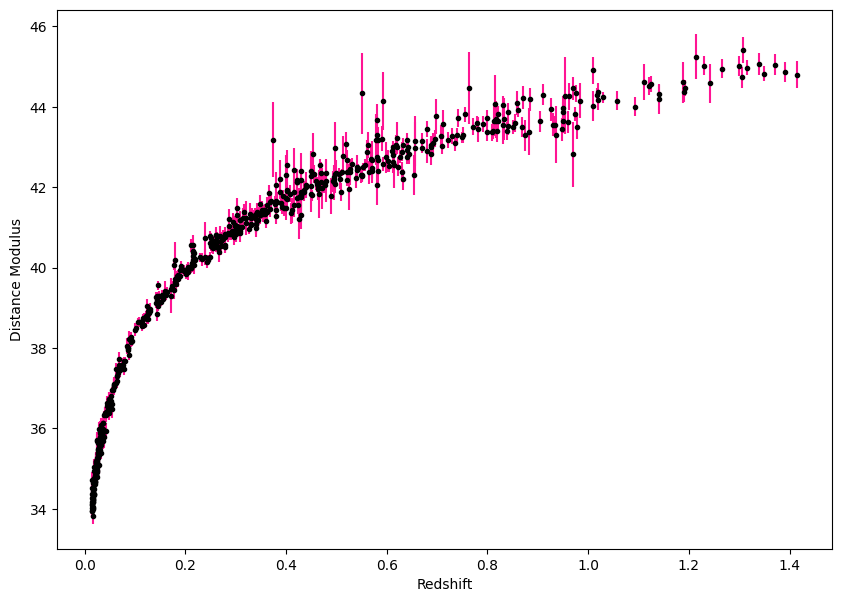

In [12]:
# Recommendation: you might want to try your functions here, and check that for Omega_m = 0.3 and Omega_L = 0.7 you get a decent match to the data
%matplotlib inline

# Plot distance modulus versus redshift (original data)
plt.figure(figsize=(10,7))
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.errorbar(zs, distance_modulus, yerr=data[:,3], fmt='o', markersize=3, color='k', ecolor='deeppink')

<ErrorbarContainer object of 3 artists>

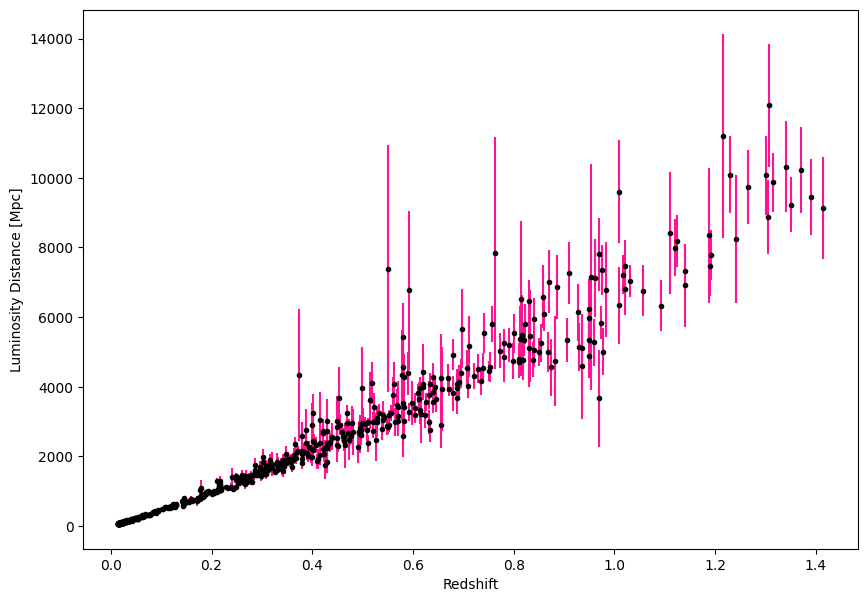

In [13]:
# Plot luminosity distance versus redshift
plt.figure(figsize = (10, 7))
plt.xlabel('Redshift')
plt.ylabel('Luminosity Distance [Mpc]')
plt.errorbar(zs, dL_Mpc, yerr=error_dL_Mpc, fmt='o', markersize=3, color='k', ecolor='deeppink')

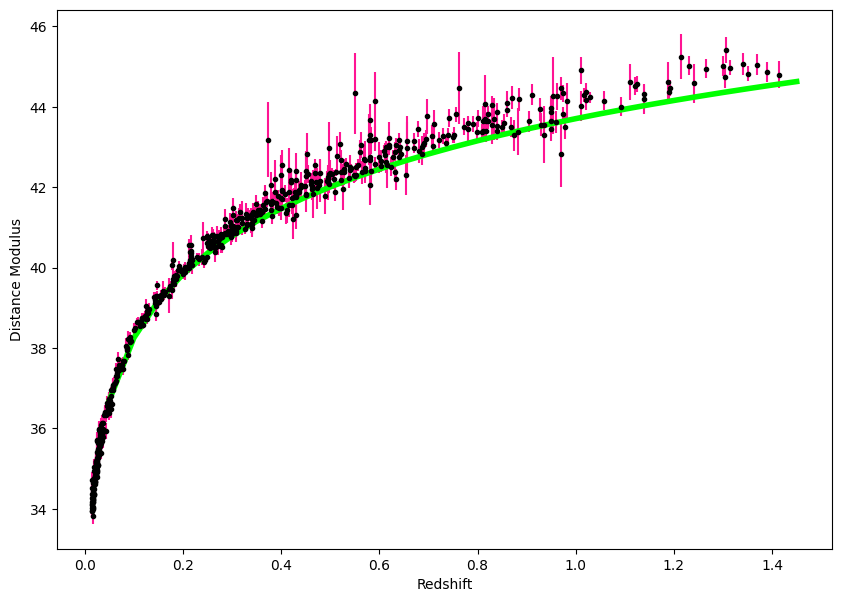

In [14]:
## comparing data to the model

plt.figure(figsize=(10,7))
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.errorbar(zs, distance_modulus, yerr= error_distance_modulus, fmt='o', markersize=3, color='k', ecolor='deeppink')


OmegaL = 0.7
OmegaM = 0.3
h      = 0.7

modelzs = np.arange(0.05, 1.5, 0.05)
modelmus = []
for z in modelzs :
    modelmus += [mu(z, OmegaM, OmegaL, h)]

plt.plot(modelzs, modelmus, linewidth=4, color='lime')
plt.show()

## <font color='deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</font>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*).
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$.
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <font color='deepskyblue'>Prior</font>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.).

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <font color='deepskyblue'>Likelihood</font>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
\tag{5}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood.

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not unheard of, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than $10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <font color='deepskyblue'>Evidence</font>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <font color='deepskyblue'>Posterior</font>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>

![title](http://1.bp.blogspot.com/-tTx4HDejSww/ULcTeK9_V_I/AAAAAAAAA8g/PCYOH-eXGbk/s1600/frequentists_vs_bayesians.png)
![title](https://i.redd.it/5r0hwixt0m931.jpg)

## <font color='deepskyblue'>Markov-Chain Monte Carlo</font>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied.
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (5), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)


* <font color="deepskyblue"> Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values) </font>
* <font color="deepskyblue"> Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$</font>
* <font color="deepskyblue"> Draw a random number $r \in [0,1]$</font>
* <font color="deepskyblue"> Accept the step if
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$</font>
    * <font color="deepskyblue"> If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$</font>
    * <font color="deepskyblue">If you want, you can keep a record of the best fit (lowest $\chi^2$), but this is not the specific purpose of MCMC! We are exploring the parameter space and sampling a _posterior distribution_, not just finding the best fit</font>
* <font color="deepskyblue"> Record the step - including **re-recording** if the step was not accepted! </font>
* <font color="deepskyblue"> Repeat</font>

In [29]:
# You don't actually need to write your data on a file (you could just store it in some np.array)
# but it tends to be a good idea, so that you run a good, long MCMC once, and then you can do all the
# analysis later on at any time, without having to produce the data again

# Choose your favourite filename
filename = "MC_Chain_SNIa.txt"
file = open(filename, "w")

# A few thousand *ACCEPTED* steps is a decent ballpark for the minimum length of your MCMC chain
# NB: start with a few hundreds, see if everything works as expected, and then commit to a longer run (>= 5000 steps)
N_steps = 5000

# Start from some very bad values, to show that the MCMC works anyway!
# (making sure you don't divide by zero anywhere...)
Omega_M = 0.1
Omega_L = 0.1
h = 0.1

# This is the main component of the exercise:
# PUT YOUR MCMC CODE HERE!

chi2_total_best = 999999999
chi2_total_list = []

OmegaM_list = []
OmegaL_list = []
h_list = []

for i in range(N_steps) :

    # pick a random step for all starting values
    Omega_M_new = Omega_M + np.random.normal(0, 0.1)
    Omega_L_new = Omega_L + np.random.normal(0, 0.1)
    h_new       = h       + np.random.normal(0, 0.1)

    OmegaM_list += [Omega_M_new] # using these values for plotting GetDist
    OmegaL_list += [Omega_L_new]
    h_list += [h_new]

    if(Omega_M_new < 0.0) : continue
    if(Omega_L_new < 0.0) : continue
    if(h_new < 0.0) : continue

    print("Values: h = {} , Omega_M = {} , Omega_L = {}".format(Omega_M_new, Omega_L_new, h_new))

    # loop over all datapoints
    chi2_total = 0.
    for i in range(len(zs)) :
        mu_model = mu(zs[i], Omega_M_new, Omega_L_new, h_new)
        chi2 = (mu_model - distance_modulus[i])**2 / error_distance_modulus[i]**2
        chi2_total += chi2

    if np.isnan(chi2_total) : continue

    print("Chi2 total = {}".format(chi2_total))

    # condition for when a better chi2 has been found
    if(chi2_total < chi2_total_best) :
        print("This is a better point!")
        # changing the starting values of the new loop to the newly gained better values
        Omega_M = Omega_M_new
        Omega_L = Omega_L_new
        h       = h_new
        chi2_total_best = chi2_total
        chi2_total_list += [chi2_total] # adding the succesful step to a list for plotting

file.close();

Streaming output truncated to the last 5000 lines.
Values: h = 0.6070022373652632 , Omega_M = 0.24580351805525177 , Omega_L = 0.6005704244680358
Chi2 total = 2518.338130015906
Values: h = 0.9083247681179882 , Omega_M = 0.40878627955264746 , Omega_L = 0.6506544004894194
Chi2 total = 1113.3875246365772
Values: h = 0.7023361055070727 , Omega_M = 0.06813131506960438 , Omega_L = 0.6986792832182054
Chi2 total = 656.5773012690715
Values: h = 0.6837502332317614 , Omega_M = 0.3611503920854119 , Omega_L = 0.6606363297118796
Chi2 total = 774.2478324668551
Values: h = 0.8654178833210606 , Omega_M = 0.16364113141169226 , Omega_L = 0.7813875655513051
Chi2 total = 1269.8130768288845
Values: h = 0.6929150239059889 , Omega_M = 0.27535831345881306 , Omega_L = 0.6888034838735803
Chi2 total = 579.8121042655465
Values: h = 0.824847783183845 , Omega_M = 0.20917841508065393 , Omega_L = 0.632218648828174
Chi2 total = 1864.1090153164387
Values: h = 0.8006147296045504 , Omega_M = 0.3349596939087027 , Omega_L = 

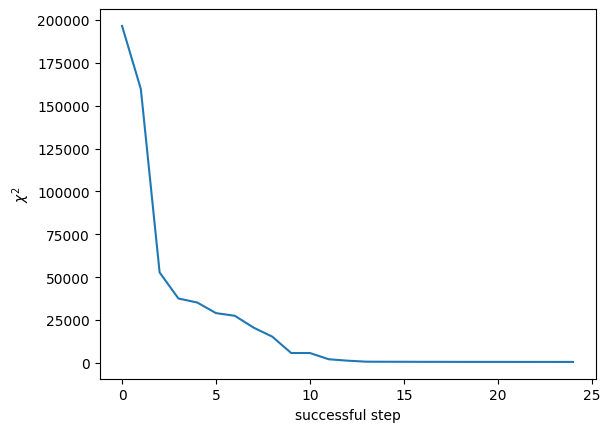

Best values: h = 0.7005992320507828 , Omega_M = 0.7467580545814694 , Omega_L = 0.29610536252806385


In [30]:
# plotting all succesful steps that were saved in chi2_total_list
plt.plot(chi2_total_list)
plt.xlabel("successful step")
plt.ylabel("$\chi^{2}$")
plt.show()

print("Best values: h = {} , Omega_M = {} , Omega_L = {}".format(h, Omega_M, Omega_L))

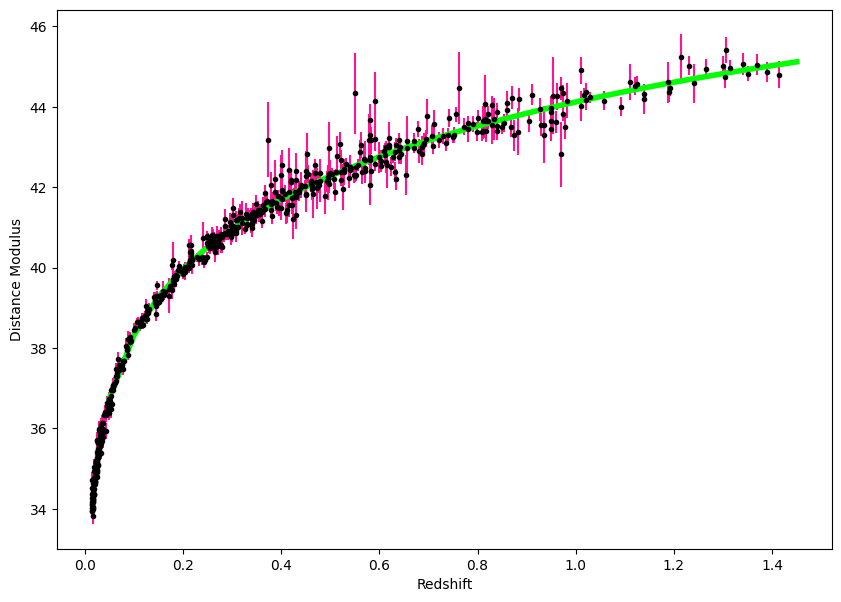

In [31]:
# plotting the output of the MCMC to the model
plt.figure(figsize=(10,7))
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.errorbar(zs, distance_modulus, yerr= error_distance_modulus, fmt='o', markersize=3, color='k', ecolor='deeppink')

modelzs = np.arange(0.05, 1.5, 0.05)
modelmus = []
for z in modelzs :
    modelmus += [mu(z, Omega_M, Omega_L, h)]

plt.plot(modelzs, modelmus, linewidth=4, color='lime')
plt.show()

In [18]:
# attempt on improving the MCMC code from above
function = np.vectorize(mu)
mu_vec = lambda h, OmegaM, OmegaL: function(zs, h, OmegaM, OmegaL)

#defining chi2 function
def chi2(OmegaM, OmegaL, h):
    return np.sum(np.square(np.subtract(mu_vec(h,OmegaM, OmegaL), distance_modulus)) / (np.square(error_distance_modulus)))

#defining new parameters
def new_parameters(OmegaM, OmegaL, h):
    OmegaM_new = OmegaM + np.random.normal(0, 0.1)
    OmegaL_new = OmegaL + np.random.normal(0, 0.1)
    h_new      = h      + np.random.normal(0, 0.1)
    return np.array([h_new, OmegaM_new, OmegaL_new])

#defining criteria whether to accept or reject new parameters
def accept_crit(chi2_current, chi2_new):
    r = np.random.uniform(0,1) #random number between 0 and 1
    #accept new parameters when new chi2 is lower than the current
    #or accept if new chi2 is lower than current and the random number is smaller than the exponential of the two chi2 values divided by 2

    if(chi2_new < chi2_current):
        return True
    elif(r < (np.exp(-(chi2_new - chi2_current) / 2))):
        return True
    else:
        return False

accepted = []  # list of accepted chi2 values
n = 1          # step counter
N_steps = 5000  # number of steps
theta0 = np.array([0.1, 0.1, 0.1])  #initial parameters

filename = "MC_Chain_SNIa.txt"

chi2_current = chi2 (*theta0) #adding initial parameters to chi2

with(open(filename, 'w') as f):

    while(n <= N_steps):
       print(f'step {n}/{N_steps}') #keeping track of the steps
       #proposing new set of parameters
       theta_new = new_parameters (*theta0)
       chi2_new = chi2 (*theta_new)

        #accept or reject the new parameters
       if(accept_crit(chi2_current, chi2_new)):
            print('Succesful step!')
            #when parameters are accepted, we change the current parameters to the new ones
            theta0 = theta_new
            chi2_current = chi2_new
            accepted += [chi2_current]
       #increase step counter by 1
       n += 1

step 1/5000
step 2/5000
Succesful step!
step 3/5000
step 4/5000
step 5/5000
step 6/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 7/5000
step 8/5000
step 9/5000
step 10/5000
step 11/5000
step 12/5000
step 13/5000
step 14/5000
Succesful step!
step 15/5000
step 16/5000
step 17/5000
step 18/5000
step 19/5000
step 20/5000
step 21/5000
step 22/5000
step 23/5000
step 24/5000
step 25/5000
step 26/5000
step 27/5000
step 28/5000
step 29/5000
step 30/5000
step 31/5000
step 32/5000
step 33/5000
step 34/5000
step 35/5000
step 36/5000
step 37/5000
step 38/5000
step 39/5000
step 40/5000
step 41/5000
step 42/5000
step 43/5000
step 44/5000
step 45/5000
step 46/5000
step 47/5000
step 48/5000
step 49/5000
step 50/5000
step 51/5000
step 52/5000
step 53/5000
step 54/5000
step 55/5000
step 56/5000
step 57/5000
step 58/5000
step 59/5000
step 60/5000
step 61/5000
step 62/5000
step 63/5000
step 64/5000
step 65/5000
step 66/5000
step 67/5000
step 68/5000
step 69/5000
step 70/5000
step 71/5000
step 72/5000
step 73/5000
step 74/5000
step 75/5000
step 76/5000
step 77/5000
step 78/5000
step 79/5000
step 80/5000
step 81/5000
step 82/5000

<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 102/5000
step 103/5000
step 104/5000
step 105/5000
step 106/5000
step 107/5000
step 108/5000
step 109/5000
step 110/5000
step 111/5000
step 112/5000
step 113/5000
step 114/5000
step 115/5000
step 116/5000
step 117/5000
step 118/5000
step 119/5000
step 120/5000
step 121/5000
step 122/5000
step 123/5000
step 124/5000
step 125/5000
step 126/5000
step 127/5000
step 128/5000
step 129/5000
step 130/5000
step 131/5000
step 132/5000
step 133/5000
step 134/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 135/5000
step 136/5000
step 137/5000
step 138/5000
step 139/5000
step 140/5000
step 141/5000
step 142/5000
step 143/5000
step 144/5000
step 145/5000
step 146/5000
step 147/5000
step 148/5000
step 149/5000
step 150/5000
step 151/5000
step 152/5000
step 153/5000
step 154/5000
step 155/5000
step 156/5000
step 157/5000
step 158/5000
step 159/5000
step 160/5000
step 161/5000
step 162/5000
step 163/5000
Succesful step!
step 164/5000
step 165/5000
Succesful step!
step 166/5000
step 167/5000
step 168/5000
step 169/5000
step 170/5000
step 171/5000
step 172/5000
Succesful step!
step 173/5000
step 174/5000
step 175/5000
step 176/5000
step 177/5000
step 178/5000
step 179/5000
step 180/5000
step 181/5000
step 182/5000
step 183/5000
step 184/5000
step 185/5000
step 186/5000
step 187/5000
step 188/5000
step 189/5000
step 190/5000
step 191/5000
step 192/5000
step 193/5000
step 194/5000
step 195/5000
step 196/5000
step 197/5000
step 198/5000
step 199/5000
step 200/5000
step 201/5000
step 202/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 219/5000
step 220/5000
step 221/5000
step 222/5000
step 223/5000
step 224/5000
step 225/5000
step 226/5000
step 227/5000
step 228/5000
step 229/5000
step 230/5000
step 231/5000
step 232/5000
step 233/5000
step 234/5000
step 235/5000
step 236/5000
step 237/5000
step 238/5000
step 239/5000
step 240/5000
step 241/5000
step 242/5000
step 243/5000
step 244/5000
step 245/5000
step 246/5000
step 247/5000
step 248/5000
step 249/5000
step 250/5000
step 251/5000
step 252/5000
step 253/5000
step 254/5000
step 255/5000
step 256/5000
step 257/5000
step 258/5000
step 259/5000
step 260/5000
step 261/5000
step 262/5000
step 263/5000
step 264/5000
step 265/5000
step 266/5000
step 267/5000
step 268/5000
step 269/5000
step 270/5000
step 271/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 272/5000
step 273/5000
step 274/5000
step 275/5000
step 276/5000
step 277/5000
step 278/5000
step 279/5000
step 280/5000
step 281/5000
step 282/5000
step 283/5000
step 284/5000
step 285/5000
step 286/5000
step 287/5000
step 288/5000
step 289/5000
step 290/5000
step 291/5000
step 292/5000
step 293/5000
step 294/5000
step 295/5000
step 296/5000
step 297/5000
step 298/5000
step 299/5000
step 300/5000
step 301/5000
step 302/5000
step 303/5000
step 304/5000
step 305/5000
step 306/5000
step 307/5000
step 308/5000
step 309/5000
step 310/5000
step 311/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 312/5000
step 313/5000
step 314/5000
step 315/5000
step 316/5000
step 317/5000
step 318/5000
step 319/5000
step 320/5000
step 321/5000
step 322/5000
step 323/5000
step 324/5000
step 325/5000
step 326/5000
step 327/5000
step 328/5000
step 329/5000
step 330/5000
step 331/5000
step 332/5000
step 333/5000
step 334/5000
step 335/5000
step 336/5000
step 337/5000
step 338/5000
step 339/5000
step 340/5000
step 341/5000
step 342/5000
step 343/5000
step 344/5000
step 345/5000
step 346/5000
step 347/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 348/5000
step 349/5000
step 350/5000
step 351/5000
step 352/5000
step 353/5000
step 354/5000
step 355/5000
step 356/5000
step 357/5000
step 358/5000
step 359/5000
step 360/5000
step 361/5000
step 362/5000
step 363/5000
step 364/5000
step 365/5000
step 366/5000
step 367/5000
step 368/5000
step 369/5000
step 370/5000
step 371/5000
step 372/5000
step 373/5000
step 374/5000
step 375/5000
step 376/5000
step 377/5000
step 378/5000
step 379/5000
step 380/5000
step 381/5000
step 382/5000
step 383/5000
step 384/5000
step 385/5000
step 386/5000
step 387/5000
step 388/5000
step 389/5000
step 390/5000
step 391/5000
step 392/5000
step 393/5000
step 394/5000
step 395/5000
step 396/5000
step 397/5000
step 398/5000
step 399/5000
step 400/5000
step 401/5000
step 402/5000
step 403/5000
step 404/5000
step 405/5000
step 406/5000
step 407/5000
step 408/5000
step 409/5000
step 410/5000
step 411/5000
step 412/5000
step 413/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 414/5000
step 415/5000
step 416/5000
step 417/5000
step 418/5000
step 419/5000
step 420/5000
step 421/5000
step 422/5000
step 423/5000
step 424/5000
step 425/5000
step 426/5000
step 427/5000
step 428/5000
step 429/5000
step 430/5000
step 431/5000
step 432/5000
step 433/5000
step 434/5000
step 435/5000
step 436/5000
step 437/5000
step 438/5000
step 439/5000
step 440/5000
step 441/5000
step 442/5000
step 443/5000
step 444/5000
step 445/5000
step 446/5000
step 447/5000
step 448/5000
step 449/5000
step 450/5000
step 451/5000
step 452/5000
step 453/5000
step 454/5000
step 455/5000
step 456/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 457/5000
step 458/5000
step 459/5000
step 460/5000
step 461/5000
step 462/5000
step 463/5000
step 464/5000
step 465/5000
step 466/5000
step 467/5000
step 468/5000
step 469/5000
step 470/5000
step 471/5000
step 472/5000
step 473/5000
step 474/5000
step 475/5000
step 476/5000
step 477/5000
step 478/5000
step 479/5000
step 480/5000
step 481/5000
step 482/5000
step 483/5000
step 484/5000
step 485/5000
step 486/5000
step 487/5000
step 488/5000
step 489/5000
step 490/5000
step 491/5000
step 492/5000
step 493/5000
step 494/5000
step 495/5000
step 496/5000
step 497/5000
step 498/5000
step 499/5000
step 500/5000
step 501/5000
step 502/5000
step 503/5000
step 504/5000
step 505/5000
step 506/5000
step 507/5000
step 508/5000
step 509/5000
step 510/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 511/5000
step 512/5000
step 513/5000
step 514/5000
step 515/5000
step 516/5000
step 517/5000
step 518/5000
step 519/5000
step 520/5000
step 521/5000
step 522/5000
step 523/5000
step 524/5000
step 525/5000
step 526/5000
step 527/5000
step 528/5000
step 529/5000
step 530/5000
step 531/5000
step 532/5000
step 533/5000
step 534/5000
step 535/5000
step 536/5000
step 537/5000
step 538/5000
step 539/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 540/5000
step 541/5000
step 542/5000
step 543/5000
step 544/5000
step 545/5000
step 546/5000
step 547/5000
step 548/5000
step 549/5000
step 550/5000
step 551/5000
step 552/5000
step 553/5000
step 554/5000
step 555/5000
step 556/5000
step 557/5000
step 558/5000
step 559/5000
step 560/5000
step 561/5000
step 562/5000
step 563/5000
step 564/5000
step 565/5000
step 566/5000
step 567/5000
step 568/5000
step 569/5000
step 570/5000
step 571/5000
step 572/5000
step 573/5000
step 574/5000
step 575/5000
step 576/5000
step 577/5000
step 578/5000
step 579/5000
step 580/5000
step 581/5000
step 582/5000
step 583/5000
step 584/5000
step 585/5000
step 586/5000
step 587/5000
step 588/5000
step 589/5000
step 590/5000
step 591/5000
step 592/5000
step 593/5000
step 594/5000
step 595/5000
step 596/5000
step 597/5000
step 598/5000
step 599/5000
step 600/5000
step 601/5000
step 602/5000
step 603/5000
step 604/5000
step 605/5000
step 606/5000
step 607/5000
step 608/5000
step 609/5000
step 610/5000
step 6

<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 613/5000
step 614/5000
step 615/5000
step 616/5000
step 617/5000
step 618/5000
step 619/5000
step 620/5000
step 621/5000
step 622/5000
step 623/5000
step 624/5000
step 625/5000
step 626/5000
step 627/5000
step 628/5000
step 629/5000
step 630/5000
step 631/5000
step 632/5000
step 633/5000
step 634/5000
step 635/5000
step 636/5000
step 637/5000
step 638/5000
step 639/5000
step 640/5000
step 641/5000
step 642/5000
step 643/5000
step 644/5000
step 645/5000
step 646/5000
step 647/5000
step 648/5000
step 649/5000
step 650/5000
step 651/5000
step 652/5000
step 653/5000
step 654/5000
step 655/5000
step 656/5000
step 657/5000
step 658/5000
step 659/5000
step 660/5000
step 661/5000
step 662/5000
step 663/5000
step 664/5000
step 665/5000
step 666/5000
step 667/5000
step 668/5000
step 669/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 670/5000
step 671/5000
step 672/5000
step 673/5000
step 674/5000
step 675/5000
step 676/5000
step 677/5000
step 678/5000
step 679/5000
step 680/5000
step 681/5000
step 682/5000
step 683/5000
step 684/5000
step 685/5000
step 686/5000
step 687/5000
step 688/5000
step 689/5000
step 690/5000
step 691/5000
step 692/5000
step 693/5000
step 694/5000
step 695/5000
step 696/5000
step 697/5000
step 698/5000
step 699/5000
step 700/5000
step 701/5000
step 702/5000
step 703/5000
step 704/5000
step 705/5000
step 706/5000
step 707/5000
step 708/5000
step 709/5000
step 710/5000
step 711/5000
step 712/5000
step 713/5000
step 714/5000
step 715/5000
step 716/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 717/5000
step 718/5000
step 719/5000
step 720/5000
step 721/5000
step 722/5000
step 723/5000
step 724/5000
step 725/5000
step 726/5000
step 727/5000
step 728/5000
step 729/5000
step 730/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 731/5000
step 732/5000
step 733/5000
step 734/5000
step 735/5000
step 736/5000
step 737/5000
step 738/5000
step 739/5000
step 740/5000
step 741/5000
step 742/5000
step 743/5000
step 744/5000
step 745/5000
step 746/5000
step 747/5000
step 748/5000
step 749/5000
step 750/5000
step 751/5000
step 752/5000
step 753/5000
step 754/5000
step 755/5000
step 756/5000
step 757/5000
step 758/5000
step 759/5000
step 760/5000
step 761/5000
step 762/5000
step 763/5000
step 764/5000
step 765/5000
step 766/5000
step 767/5000
step 768/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 769/5000
step 770/5000
step 771/5000
step 772/5000
step 773/5000
step 774/5000
step 775/5000
step 776/5000
step 777/5000
step 778/5000
step 779/5000
step 780/5000
step 781/5000
step 782/5000
step 783/5000
step 784/5000
step 785/5000
step 786/5000
step 787/5000
step 788/5000
step 789/5000
step 790/5000
step 791/5000
step 792/5000
step 793/5000
step 794/5000
step 795/5000
step 796/5000
step 797/5000
step 798/5000
step 799/5000
step 800/5000
step 801/5000
step 802/5000
step 803/5000
step 804/5000
Succesful step!
step 805/5000
step 806/5000
step 807/5000
step 808/5000
step 809/5000
step 810/5000
step 811/5000
step 812/5000
step 813/5000
step 814/5000
step 815/5000
step 816/5000
step 817/5000
step 818/5000
step 819/5000
step 820/5000
step 821/5000
step 822/5000
step 823/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 824/5000
step 825/5000
step 826/5000
step 827/5000
step 828/5000
step 829/5000
step 830/5000
step 831/5000
step 832/5000
step 833/5000
step 834/5000
step 835/5000
step 836/5000
step 837/5000
step 838/5000
step 839/5000
step 840/5000
step 841/5000
step 842/5000
step 843/5000
step 844/5000
step 845/5000
step 846/5000
step 847/5000
step 848/5000
step 849/5000
step 850/5000
step 851/5000
step 852/5000
step 853/5000
step 854/5000
step 855/5000
step 856/5000
step 857/5000
step 858/5000
step 859/5000
step 860/5000
step 861/5000
step 862/5000
step 863/5000
step 864/5000
step 865/5000
step 866/5000
step 867/5000
step 868/5000
step 869/5000
step 870/5000
step 871/5000
step 872/5000
step 873/5000
step 874/5000
step 875/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 876/5000
step 877/5000
step 878/5000
step 879/5000
step 880/5000
step 881/5000
step 882/5000
step 883/5000
step 884/5000
step 885/5000
step 886/5000
step 887/5000
step 888/5000
step 889/5000
step 890/5000
step 891/5000
step 892/5000
step 893/5000
step 894/5000
step 895/5000
step 896/5000
step 897/5000
step 898/5000
step 899/5000
step 900/5000
step 901/5000
step 902/5000
step 903/5000
step 904/5000
step 905/5000
step 906/5000
step 907/5000
step 908/5000
step 909/5000
step 910/5000
step 911/5000
step 912/5000
step 913/5000
step 914/5000
step 915/5000
step 916/5000
step 917/5000
step 918/5000
step 919/5000
step 920/5000
step 921/5000
step 922/5000
step 923/5000
step 924/5000
step 925/5000
step 926/5000
step 927/5000
step 928/5000
step 929/5000
step 930/5000
step 931/5000
step 932/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 933/5000
step 934/5000
step 935/5000
step 936/5000
step 937/5000
step 938/5000
step 939/5000
step 940/5000
step 941/5000
step 942/5000
step 943/5000
step 944/5000
step 945/5000
step 946/5000
step 947/5000
step 948/5000
step 949/5000
step 950/5000
step 951/5000
step 952/5000
step 953/5000
step 954/5000
step 955/5000
step 956/5000
step 957/5000
step 958/5000
step 959/5000
step 960/5000
step 961/5000
step 962/5000
step 963/5000
step 964/5000
step 965/5000
step 966/5000
step 967/5000
step 968/5000
step 969/5000
step 970/5000
step 971/5000
step 972/5000
step 973/5000
step 974/5000
step 975/5000
step 976/5000
step 977/5000
step 978/5000
step 979/5000
step 980/5000
step 981/5000
step 982/5000
step 983/5000
step 984/5000
step 985/5000
step 986/5000
step 987/5000
step 988/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 989/5000
step 990/5000
step 991/5000
step 992/5000
step 993/5000
step 994/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 995/5000
step 996/5000
step 997/5000
step 998/5000
step 999/5000
step 1000/5000
step 1001/5000
step 1002/5000
step 1003/5000
step 1004/5000
step 1005/5000
step 1006/5000
step 1007/5000
step 1008/5000
step 1009/5000
step 1010/5000
step 1011/5000
step 1012/5000
step 1013/5000
step 1014/5000
step 1015/5000
step 1016/5000
step 1017/5000
step 1018/5000
step 1019/5000
step 1020/5000
step 1021/5000
step 1022/5000
step 1023/5000
step 1024/5000
step 1025/5000
step 1026/5000
step 1027/5000
step 1028/5000
step 1029/5000
step 1030/5000
step 1031/5000
step 1032/5000
step 1033/5000
step 1034/5000
step 1035/5000
step 1036/5000
step 1037/5000
step 1038/5000
step 1039/5000
step 1040/5000
step 1041/5000
step 1042/5000
step 1043/5000
step 1044/5000
step 1045/5000
step 1046/5000
step 1047/5000
step 1048/5000
step 1049/5000
step 1050/5000
step 1051/5000
step 1052/5000
step 1053/5000
step 1054/5000
step 1055/5000
step 1056/5000
step 1057/5000
step 1058/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1059/5000
step 1060/5000
step 1061/5000
step 1062/5000
step 1063/5000
step 1064/5000
step 1065/5000
step 1066/5000
step 1067/5000
step 1068/5000
step 1069/5000
step 1070/5000
step 1071/5000
step 1072/5000
step 1073/5000
step 1074/5000
step 1075/5000
step 1076/5000
step 1077/5000
step 1078/5000
step 1079/5000
step 1080/5000
step 1081/5000
step 1082/5000
step 1083/5000
step 1084/5000
step 1085/5000
step 1086/5000
step 1087/5000
step 1088/5000
step 1089/5000
step 1090/5000
step 1091/5000
step 1092/5000
step 1093/5000
step 1094/5000
step 1095/5000
step 1096/5000
step 1097/5000
step 1098/5000
step 1099/5000
step 1100/5000
step 1101/5000
step 1102/5000
step 1103/5000
step 1104/5000
step 1105/5000
step 1106/5000
step 1107/5000
step 1108/5000
step 1109/5000
step 1110/5000
step 1111/5000
step 1112/5000
step 1113/5000
step 1114/5000
step 1115/5000
step 1116/5000
step 1117/5000
step 1118/5000
step 1119/5000
step 1120/5000
step 1121/5000
step 1122/5000
step 1123/5000
step 1124/5000
step 1125/

<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1138/5000
step 1139/5000
step 1140/5000
step 1141/5000
step 1142/5000
step 1143/5000
step 1144/5000
step 1145/5000
step 1146/5000
step 1147/5000
step 1148/5000
step 1149/5000
step 1150/5000
step 1151/5000
step 1152/5000
step 1153/5000
step 1154/5000
step 1155/5000
step 1156/5000
step 1157/5000
step 1158/5000
step 1159/5000
step 1160/5000
step 1161/5000
step 1162/5000
step 1163/5000
step 1164/5000
step 1165/5000
step 1166/5000
step 1167/5000
step 1168/5000
step 1169/5000
step 1170/5000
step 1171/5000
step 1172/5000
step 1173/5000
step 1174/5000
step 1175/5000
step 1176/5000
step 1177/5000
step 1178/5000
step 1179/5000
step 1180/5000
step 1181/5000
step 1182/5000
step 1183/5000
step 1184/5000
step 1185/5000
step 1186/5000
step 1187/5000
step 1188/5000
step 1189/5000
step 1190/5000
step 1191/5000
step 1192/5000
step 1193/5000
step 1194/5000
step 1195/5000
step 1196/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1197/5000
step 1198/5000
step 1199/5000
step 1200/5000
step 1201/5000
step 1202/5000
step 1203/5000
step 1204/5000
step 1205/5000
step 1206/5000
step 1207/5000
step 1208/5000
step 1209/5000
step 1210/5000
step 1211/5000
step 1212/5000
step 1213/5000
step 1214/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1215/5000
step 1216/5000
step 1217/5000
step 1218/5000
step 1219/5000
step 1220/5000
step 1221/5000
step 1222/5000
step 1223/5000
step 1224/5000
step 1225/5000
step 1226/5000
step 1227/5000
step 1228/5000
step 1229/5000
step 1230/5000
step 1231/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1232/5000
step 1233/5000
step 1234/5000
step 1235/5000
step 1236/5000
step 1237/5000
step 1238/5000
step 1239/5000
step 1240/5000
step 1241/5000
step 1242/5000
step 1243/5000
step 1244/5000
step 1245/5000
step 1246/5000
step 1247/5000
step 1248/5000
step 1249/5000
step 1250/5000
step 1251/5000
step 1252/5000
step 1253/5000
step 1254/5000
step 1255/5000
step 1256/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1257/5000
step 1258/5000
step 1259/5000
step 1260/5000
step 1261/5000
step 1262/5000
step 1263/5000
step 1264/5000
step 1265/5000
step 1266/5000
step 1267/5000
step 1268/5000
step 1269/5000
step 1270/5000
step 1271/5000
step 1272/5000
step 1273/5000
step 1274/5000
step 1275/5000
step 1276/5000
step 1277/5000
step 1278/5000
step 1279/5000
step 1280/5000
step 1281/5000
step 1282/5000
step 1283/5000
step 1284/5000
step 1285/5000
step 1286/5000
step 1287/5000
step 1288/5000
step 1289/5000
step 1290/5000
step 1291/5000
step 1292/5000
step 1293/5000
step 1294/5000
step 1295/5000
step 1296/5000
step 1297/5000
step 1298/5000
step 1299/5000
step 1300/5000
step 1301/5000
step 1302/5000
step 1303/5000
step 1304/5000
step 1305/5000
step 1306/5000
step 1307/5000
step 1308/5000
step 1309/5000
step 1310/5000
step 1311/5000
step 1312/5000
step 1313/5000
step 1314/5000
step 1315/5000
step 1316/5000
step 1317/5000
step 1318/5000
step 1319/5000
step 1320/5000
step 1321/5000
step 1322/5000
step 1323/

<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1339/5000
step 1340/5000
step 1341/5000
step 1342/5000
step 1343/5000
step 1344/5000
step 1345/5000
step 1346/5000
step 1347/5000
step 1348/5000
step 1349/5000
step 1350/5000
step 1351/5000
step 1352/5000
step 1353/5000
step 1354/5000
step 1355/5000
step 1356/5000
step 1357/5000
step 1358/5000
step 1359/5000
step 1360/5000
step 1361/5000
step 1362/5000
step 1363/5000
step 1364/5000
step 1365/5000
step 1366/5000
step 1367/5000
step 1368/5000
step 1369/5000
step 1370/5000
step 1371/5000
step 1372/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1373/5000
step 1374/5000
step 1375/5000
step 1376/5000
step 1377/5000
step 1378/5000
step 1379/5000
step 1380/5000
step 1381/5000
step 1382/5000
step 1383/5000
step 1384/5000
step 1385/5000
step 1386/5000
step 1387/5000
step 1388/5000
step 1389/5000
step 1390/5000
step 1391/5000
step 1392/5000
step 1393/5000
step 1394/5000
step 1395/5000
step 1396/5000
step 1397/5000
step 1398/5000
step 1399/5000
step 1400/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1401/5000
step 1402/5000
step 1403/5000
step 1404/5000
step 1405/5000
step 1406/5000
step 1407/5000
step 1408/5000
step 1409/5000
step 1410/5000
step 1411/5000
step 1412/5000
step 1413/5000
step 1414/5000
step 1415/5000
step 1416/5000
step 1417/5000
step 1418/5000
step 1419/5000
step 1420/5000
step 1421/5000
step 1422/5000
step 1423/5000
step 1424/5000
step 1425/5000
step 1426/5000
step 1427/5000
step 1428/5000
step 1429/5000
step 1430/5000
step 1431/5000
step 1432/5000
step 1433/5000
step 1434/5000
step 1435/5000
step 1436/5000
step 1437/5000
step 1438/5000
step 1439/5000
step 1440/5000
step 1441/5000
step 1442/5000
step 1443/5000
step 1444/5000
step 1445/5000
step 1446/5000
step 1447/5000
step 1448/5000
step 1449/5000
step 1450/5000
step 1451/5000
step 1452/5000
step 1453/5000
step 1454/5000
step 1455/5000
step 1456/5000
step 1457/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1458/5000
step 1459/5000
step 1460/5000
step 1461/5000
step 1462/5000
step 1463/5000
step 1464/5000
step 1465/5000
step 1466/5000
step 1467/5000
step 1468/5000
step 1469/5000
step 1470/5000
step 1471/5000
step 1472/5000
step 1473/5000
step 1474/5000
step 1475/5000
step 1476/5000
step 1477/5000
step 1478/5000
step 1479/5000
step 1480/5000
step 1481/5000
step 1482/5000
step 1483/5000
step 1484/5000
step 1485/5000
step 1486/5000
step 1487/5000
step 1488/5000
step 1489/5000
step 1490/5000
step 1491/5000
step 1492/5000
step 1493/5000
step 1494/5000
step 1495/5000
step 1496/5000
step 1497/5000
step 1498/5000
step 1499/5000
step 1500/5000
step 1501/5000
step 1502/5000
step 1503/5000
step 1504/5000
step 1505/5000
step 1506/5000
step 1507/5000
step 1508/5000
step 1509/5000
step 1510/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1511/5000
step 1512/5000
step 1513/5000
step 1514/5000
step 1515/5000
step 1516/5000
step 1517/5000
step 1518/5000
step 1519/5000
step 1520/5000
step 1521/5000
step 1522/5000
step 1523/5000
step 1524/5000
step 1525/5000
step 1526/5000
step 1527/5000
step 1528/5000
step 1529/5000
step 1530/5000
step 1531/5000
step 1532/5000
step 1533/5000
step 1534/5000
step 1535/5000
step 1536/5000
step 1537/5000
step 1538/5000
step 1539/5000
step 1540/5000
step 1541/5000
step 1542/5000
step 1543/5000
step 1544/5000
step 1545/5000
step 1546/5000
step 1547/5000
step 1548/5000
step 1549/5000
step 1550/5000
step 1551/5000
step 1552/5000
step 1553/5000
step 1554/5000
step 1555/5000
step 1556/5000
step 1557/5000
step 1558/5000
step 1559/5000
step 1560/5000
step 1561/5000
step 1562/5000
step 1563/5000
step 1564/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1565/5000
step 1566/5000
step 1567/5000
step 1568/5000
step 1569/5000
step 1570/5000
step 1571/5000
step 1572/5000
step 1573/5000
step 1574/5000
step 1575/5000
step 1576/5000
step 1577/5000
step 1578/5000
step 1579/5000
step 1580/5000
step 1581/5000
step 1582/5000
step 1583/5000
step 1584/5000
step 1585/5000
step 1586/5000
step 1587/5000
step 1588/5000
step 1589/5000
step 1590/5000
step 1591/5000
step 1592/5000
step 1593/5000
step 1594/5000
step 1595/5000
step 1596/5000
step 1597/5000
step 1598/5000
step 1599/5000
step 1600/5000
step 1601/5000
step 1602/5000
step 1603/5000
step 1604/5000
step 1605/5000
step 1606/5000
step 1607/5000
step 1608/5000
step 1609/5000
step 1610/5000
step 1611/5000
step 1612/5000
step 1613/5000
step 1614/5000
step 1615/5000
step 1616/5000
step 1617/5000
step 1618/5000
step 1619/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1620/5000
step 1621/5000
step 1622/5000
step 1623/5000
step 1624/5000
step 1625/5000
step 1626/5000
step 1627/5000
step 1628/5000
step 1629/5000
step 1630/5000
step 1631/5000
step 1632/5000
step 1633/5000
step 1634/5000
step 1635/5000
step 1636/5000
step 1637/5000
step 1638/5000
step 1639/5000
step 1640/5000
step 1641/5000
step 1642/5000
step 1643/5000
step 1644/5000
step 1645/5000
step 1646/5000
step 1647/5000
step 1648/5000
step 1649/5000
step 1650/5000
step 1651/5000
step 1652/5000
step 1653/5000
step 1654/5000
step 1655/5000
step 1656/5000
step 1657/5000
step 1658/5000
step 1659/5000
step 1660/5000
step 1661/5000
step 1662/5000
step 1663/5000
step 1664/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1665/5000
step 1666/5000
step 1667/5000
step 1668/5000
step 1669/5000
step 1670/5000
step 1671/5000
step 1672/5000
step 1673/5000
step 1674/5000
step 1675/5000
step 1676/5000
step 1677/5000
step 1678/5000
step 1679/5000
step 1680/5000
step 1681/5000
step 1682/5000
step 1683/5000
step 1684/5000
step 1685/5000
step 1686/5000
step 1687/5000
step 1688/5000
step 1689/5000
step 1690/5000
step 1691/5000
step 1692/5000
step 1693/5000
step 1694/5000
step 1695/5000
step 1696/5000
step 1697/5000
step 1698/5000
step 1699/5000
step 1700/5000
step 1701/5000
step 1702/5000
step 1703/5000
step 1704/5000
step 1705/5000
step 1706/5000
step 1707/5000
step 1708/5000
step 1709/5000
step 1710/5000
step 1711/5000
step 1712/5000
step 1713/5000
step 1714/5000
step 1715/5000
step 1716/5000
step 1717/5000
step 1718/5000


<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1719/5000
step 1720/5000
step 1721/5000
step 1722/5000
step 1723/5000
step 1724/5000
step 1725/5000
step 1726/5000
step 1727/5000
step 1728/5000
step 1729/5000
step 1730/5000
step 1731/5000
step 1732/5000
step 1733/5000
step 1734/5000
step 1735/5000
step 1736/5000
step 1737/5000
step 1738/5000
step 1739/5000
step 1740/5000
step 1741/5000
step 1742/5000
step 1743/5000
step 1744/5000
step 1745/5000
step 1746/5000
step 1747/5000
step 1748/5000
step 1749/5000
step 1750/5000
step 1751/5000
step 1752/5000
step 1753/5000
step 1754/5000
step 1755/5000
step 1756/5000
step 1757/5000
step 1758/5000
step 1759/5000
step 1760/5000
step 1761/5000
step 1762/5000
step 1763/5000
step 1764/5000
step 1765/5000
step 1766/5000
step 1767/5000
step 1768/5000
step 1769/5000
step 1770/5000
step 1771/5000
step 1772/5000
step 1773/5000
step 1774/5000
step 1775/5000
step 1776/5000
step 1777/5000
step 1778/5000
step 1779/5000
step 1780/5000
step 1781/5000
step 1782/5000
step 1783/5000
step 1784/5000
step 1785/

<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)
<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1801/5000
step 1802/5000
step 1803/5000
step 1804/5000
step 1805/5000
step 1806/5000
step 1807/5000
step 1808/5000
step 1809/5000
step 1810/5000
step 1811/5000
step 1812/5000
step 1813/5000
step 1814/5000
step 1815/5000
step 1816/5000
step 1817/5000
step 1818/5000
step 1819/5000
step 1820/5000
step 1821/5000
step 1822/5000
step 1823/5000
step 1824/5000
step 1825/5000
step 1826/5000
step 1827/5000
step 1828/5000
step 1829/5000
step 1830/5000
step 1831/5000
step 1832/5000
step 1833/5000
step 1834/5000
step 1835/5000
step 1836/5000
step 1837/5000
step 1838/5000
step 1839/5000
step 1840/5000
step 1841/5000
step 1842/5000
step 1843/5000
step 1844/5000
step 1845/5000
step 1846/5000
step 1847/5000
step 1848/5000
step 1849/5000
step 1850/5000
step 1851/5000
step 1852/5000
step 1853/5000
step 1854/5000
step 1855/5000
step 1856/5000
step 1857/5000
step 1858/5000
step 1859/5000
step 1860/5000
step 1861/5000
step 1862/5000
step 1863/5000
step 1864/5000
step 1865/5000
step 1866/5000
step 1867/

<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 1883/5000
step 1884/5000
step 1885/5000
step 1886/5000
step 1887/5000
Succesful step!
step 1888/5000
Succesful step!
step 1889/5000
step 1890/5000
step 1891/5000
step 1892/5000
step 1893/5000
step 1894/5000
step 1895/5000
step 1896/5000
step 1897/5000
step 1898/5000
step 1899/5000
step 1900/5000
step 1901/5000
step 1902/5000
step 1903/5000
step 1904/5000
step 1905/5000
step 1906/5000
step 1907/5000
step 1908/5000
step 1909/5000
step 1910/5000
step 1911/5000
step 1912/5000
step 1913/5000
step 1914/5000
step 1915/5000
step 1916/5000
step 1917/5000
step 1918/5000
step 1919/5000
step 1920/5000
step 1921/5000
step 1922/5000
step 1923/5000
step 1924/5000
step 1925/5000
step 1926/5000
step 1927/5000
step 1928/5000
step 1929/5000
step 1930/5000
step 1931/5000
step 1932/5000
step 1933/5000
step 1934/5000
step 1935/5000
step 1936/5000
step 1937/5000
step 1938/5000
step 1939/5000
step 1940/5000
step 1941/5000
step 1942/5000
step 1943/5000
step 1944/5000
step 1945/5000
step 1946/5000
step 194

<ipython-input-7-70e6a2e8ac2d>:5: RuntimeWarning: invalid value encountered in log10
  muz = 5 * np.log10(dl*1e6 / 10)


step 4858/5000
step 4859/5000
step 4860/5000
step 4861/5000
step 4862/5000
step 4863/5000
step 4864/5000
step 4865/5000
step 4866/5000
step 4867/5000
step 4868/5000
step 4869/5000
step 4870/5000
step 4871/5000
step 4872/5000
step 4873/5000
step 4874/5000
step 4875/5000
step 4876/5000
step 4877/5000
step 4878/5000
step 4879/5000
step 4880/5000
step 4881/5000
step 4882/5000
step 4883/5000
step 4884/5000
step 4885/5000
step 4886/5000
step 4887/5000
step 4888/5000
step 4889/5000
step 4890/5000
step 4891/5000
step 4892/5000
step 4893/5000
step 4894/5000
step 4895/5000
step 4896/5000
step 4897/5000
step 4898/5000
step 4899/5000
step 4900/5000
step 4901/5000
step 4902/5000
step 4903/5000
step 4904/5000
step 4905/5000
step 4906/5000
step 4907/5000
step 4908/5000
step 4909/5000
step 4910/5000
step 4911/5000
step 4912/5000
step 4913/5000
step 4914/5000
step 4915/5000
step 4916/5000
step 4917/5000
step 4918/5000
step 4919/5000
step 4920/5000
step 4921/5000
step 4922/5000
step 4923/5000
step 4924/

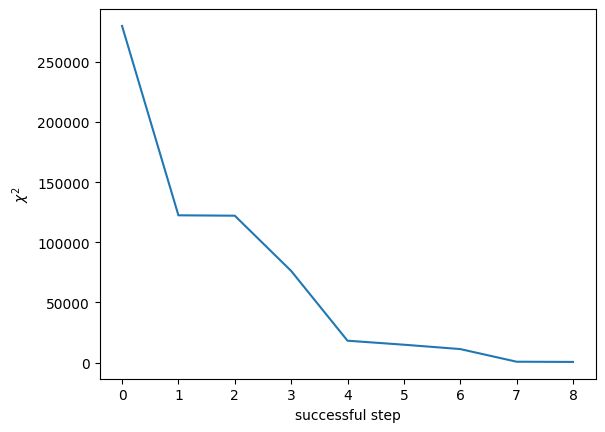

Best values: h = 0.814797444118727 , Omega_M = 0.6918309324850646 , Omega_L = 0.5647621822473338


In [19]:
# plotting all succesful steps that were saved in chi2_total_list
plt.plot(accepted)
plt.xlabel("successful step")
plt.ylabel("$\chi^{2}$")
plt.show()

print(f"Best values: h = {new_parameters(h, OmegaM, OmegaL)[0]} , Omega_M = {new_parameters(h, OmegaM, OmegaL)[1]} , Omega_L = {new_parameters(h, OmegaM, OmegaL)[2]}")

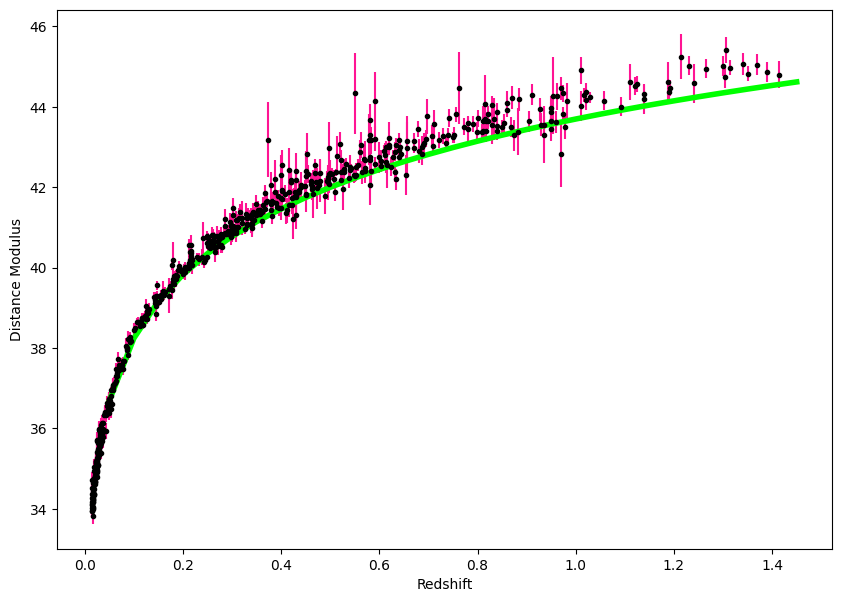

In [20]:
# plotting the output of the MCMC to the model
plt.figure(figsize=(10,7))
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.errorbar(zs, distance_modulus, yerr= error_distance_modulus, fmt='o', markersize=3, color='k', ecolor='deeppink')

modelzs = np.arange(0.05, 1.5, 0.05)
modelmus = []
for z in modelzs :
    modelmus += [mu(z, OmegaM, OmegaL, h)]

plt.plot(modelzs, modelmus, linewidth=4, color='lime')
plt.show()

After completion of the programme, your MC chain will (*hopefully*) look something like this: (note the repeated entry!)

`#Omega_m  Omega_L  h`

`0.297     0.703    0.698`

`0.285     0.715    0.701`

`0.285     0.715    0.701`

`0.288     0.712    0.699`

`...`

## <font color='deepskyblue'>Plotting: GetDist</font>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

<font color='deepskyblue'>
Look at your results. Do you obtain $\Omega_\Lambda \neq 0$? To a high degree of significance?

If yes, then my dear friend, you have **DISCOVERED THE ACCELERATED EXPANSION OF THE UNIVERSE AND WON THE NOBEL PRIZE IN PHYSICS 2011!**
</font>

Removed no burn in
0.6  <  h  <  0.8  at  68 % CL
0.59  <  OmegaM  <  0.84  at  68 % CL
0.17  <  OmegaL  <  0.38  at  68 % CL
-0.17  <  Omegak  <  0.18  at  68 % CL




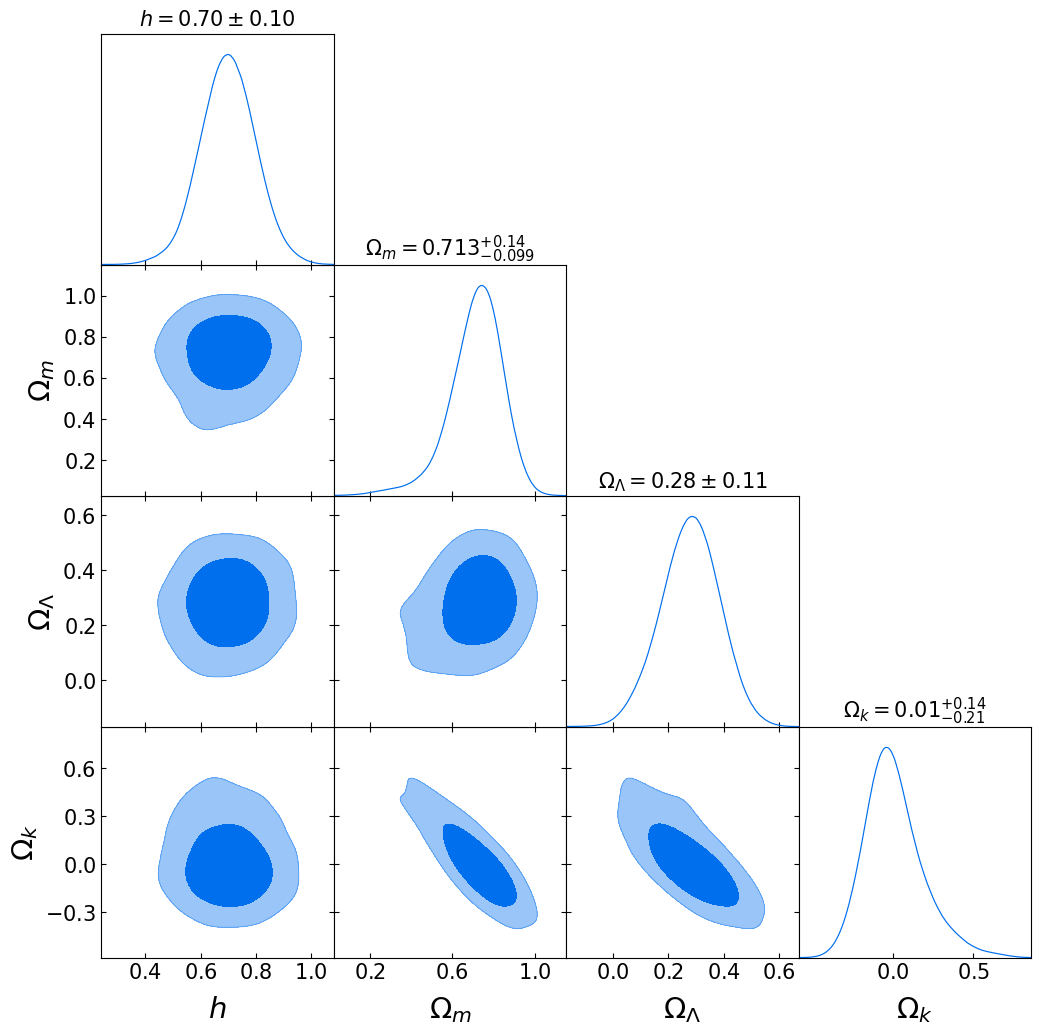

In [40]:
# converting the lists to arrays
OmegaM = np.array(OmegaM_list)
OmegaL = np.array(OmegaL_list)
h = np.array(h_list)

# You can easily create new np.arrays that are functions of other np.arrays
Omegak = 1. - OmegaM - OmegaL

# Let's define variable names and labels
my_labels = [r'h', r'\Omega_m', r'\Omega_\Lambda', r'\Omega_k']
my_names = ['h', 'OmegaM', 'OmegaL', 'Omegak']
my_dim = len(my_names) # The number of variables we're plotting

# This creates a higher-dimensional array with all our data, shaped in the appropriate way...
my_samples = np.transpose(np.reshape([h, OmegaM, OmegaL, Omegak], (my_dim, len(h))))

# ... to create an "MCSamples" data type, which GetDist can use
my_samples = MCSamples(samples = my_samples, labels = my_labels, names = my_names)

# The usual 1-sigma confidence level. You can change to 2- or 3-sigma if you want
conf_level = 0.6827

# This prints a table with the 1D posteriors (confidence levels)
for nam in my_names:
    print(round(my_samples.confidence(nam,(1.-conf_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(my_samples.confidence(nam,(1.-conf_level)/2.,upper=True),2),\
          " at " , int(100*conf_level),"\b% CL")
print("\n")

#Triangle corner plot
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(my_samples, filled = True, title_limit=1)

## <font color='deepskyblue'>Further Improvements</font>

There are many ways in which you can improve your code and/or your data visualisation. Some ideas, in random order:

* Modify your priors and compare your results. For instance:
  * Change to log-flat priors for $h$ and/or $\Omega_m$, namely displace them in log-space instead of linear space:
  $$
  \log(h_{\rm new}) = \log(h_{\rm old}) + \delta
  $$
  where $\delta$ a random variable of mean 0
  * Use priors from other cosmological probes, for example the [Planck 2018 results](https://arxiv.org/abs/1807.06209):
  $$
  \Omega_m = 0.315 \pm 0.007\,,~\dots
  $$
* Monitor acceptance ratio and $\chi^2$ as a function of step count
* Implement a Gelman-Rubin (or alternative) convergence test
* Change colours and other properties of your triangle plot
* Re-plot the data with your theoretical fits: you can try both your best fit, and some $1\sigma$ "error bars"
* Split your data in redshift bins and repeat the analysis for each bin individually.
<br> _(What do you notice? Which redshift bins give us the most accurate detection of the cosmological parameters?)_